<a href="https://colab.research.google.com/github/brokoli777/Emotion-Recogntion/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import kagglehub to download datasets from Kaggle
import kagglehub

# Download FER2013 dataset from Kaggle (didplay path for referrence)
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
# Import shutil library for file operations
import shutil

# Define source and destination paths for dataset
source = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
destination = "/content/dataset"

# Move dataset files from source to destination folder (display where moved to for referrence)
shutil.move(source, destination)
print(f"Files moved to {destination}")

Files moved to /content/dataset


In [ ]:
# Import libraries for data manipulation, visualization and warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

# Import tensorflow and keras for deep learning tools
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define the paths for training and testing directories
TRAIN_DIR = './dataset/train'
TEST_DIR = './dataset/test'

In [ ]:
# Display the contents of the dataset directories
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))

['surprise', 'angry', 'disgust', 'happy', 'neutral', 'fear', 'sad']
['surprise', 'angry', 'disgust', 'happy', 'neutral', 'fear', 'sad']


In [ ]:
# Display the number of images for specific labels in the training dataset
print(len(os.listdir(TRAIN_DIR+'/angry')))
print(len(os.listdir(TRAIN_DIR+'/disgust')))

958
111


In [ ]:
# Function to load the dataset images and their labels
def load_dataset(directory):
    image_paths = []  # List for storing image paths
    labels = []       # List for storing labels

    # Iterate through each label in the dataset directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Use os.path.join to create label path
        if not os.path.isdir(label_path):  # Skip if it's not a directory
            continue

        # Iterate through the images within the label directory
        for filename in os.listdir(label_path):
            image_path = os.path.join(label_path, filename)
            image_paths.append(image_path)  # Append image path
            labels.append(label)            # Append label

        # Display completion validation
        print(label, "Completed")

    return image_paths, labels

In [ ]:
# Convert training dataset into a DataFrame
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Mix up the training dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
angry Completed
disgust Completed
happy Completed
neutral Completed
fear Completed
sad Completed


,image,label
0,./dataset/test/neutral/PublicTest_26149578.jpg,neutral
1,./dataset/test/happy/PrivateTest_82161877.jpg,happy
2,./dataset/test/fear/PrivateTest_30999343.jpg,fear
3,./dataset/test/sad/PublicTest_44362743.jpg,sad
4,./dataset/test/fear/PrivateTest_2178829.jpg,fear


In [ ]:
# Convert the testing dataset into a DataFrame
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
angry Completed
disgust Completed
happy Completed
neutral Completed
fear Completed
sad Completed


,image,label
0,./dataset/train/surprise/Training_49449311.jpg,surprise
1,./dataset/train/surprise/Training_48668334.jpg,surprise
2,./dataset/train/surprise/Training_92129253.jpg,surprise
3,./dataset/train/surprise/Training_53726404.jpg,surprise
4,./dataset/train/surprise/Training_98737557.jpg,surprise


In [ ]:
# Function to preprocess and extract features from images
def get_features(images):
    features = [] # Empty features array
    for image in images:
        img = load_img(image, color_mode='grayscale') # Load image in grayscale
        img = np.array(img)   # Convert image to numpy array
        features.append(img)  # Append to the features list
    features = np.array(features)

    # Reshape features for model input
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
# Extract the features from training and testing datasets
train_features = get_features(train['image'])
test_features = get_features(test['image'])

In [ ]:
# Normalize the image pixel values
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
# Convert labels to integer values using LabelEncoder
from sklearn.preprocessing import LabelEncoder

# - LabelEncoder is used to transform categorical labels (strings) into integer values.
encode = LabelEncoder()

# - The `fit` method identifies all unique labels in the training data (`train['label']`).
# - It assigns a unique integer to each label.
encode.fit(train['label'])

# - Transform training and testing labels into integer values
y_train = encode.transform(train['label'])
y_test = encode.transform(test['label'])

In [ ]:
# Convert integer lables to encoded vectors
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
# Define the input shape and number of output classes for model
input_shape = (48, 48, 1)
output_class = 7

In [ ]:
# Build the CNN model
model = Sequential()
model.add(Input(shape=input_shape))

# First convolutional block
# - The 32 filters help the model learn 32 distinct patterns or features from the input data.
# - The kernel size (3x3) determines the receptive field used to scan the input.
# - ReLU (Rectified Linear Unit) activation introduces non-linearity to enable the model
#   to learn complex relationships between features.
# This layer extracts low-level features such as edges and textures from the input image.
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Add a batch normalization layer immediately after the convolutional layer.
# - This layer normalizes the outputs of the convolutional layer to have a mean of 0
#   and a standard deviation of 1, which helps stabilize the learning process.
# - It reduces sensitivity to weight initialization and allows the model to train faster.
# Batch normalization also acts as a regularizer, reducing the chances of overfitting.
model.add(BatchNormalization())

# Second convolutional block
# - Increase filters to 64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# - Add a max pooling layer with a pool size of 2x2.
# - This layer downsamples the spatial dimensions of the feature maps,
# - reducing computation and helping the model focus on dominant features.
model.add(MaxPooling2D(pool_size=(2, 2)))

# - Add a dropout layer with a dropout rate of 0.5.
# - This randomly sets 50% of the neurons to zero during training to prevent overfitting
# - and improve the generalization capability of the model.
model.add(Dropout(0.5))

# Third convolutional block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Flatten())  # Flatten feature maps

# - The large number of neurons (1024) provides the model with significant capacity
# - to learn intricate details in the data.
model.add(Dense(1024, activation='relu')) # Fully connected layer
model.add(Dropout(0.2)) # Dropout

# - Each neuron corresponds to one of the 7 emotion classes in the dataset.
# - The softmax activation function ensures that the output values represent probabilities
# - and sum to 1, making it suitable for multi-class classification tasks.
model.add(Dense(7, activation='softmax')) # Output layer

# Display the model summary
model.summary()

# Complie the model using Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 19, 19, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 17, 17, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 17, 17, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 884,679 (3.37 MB)

 Trainable params: 884,103 (3.37 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
# Setup for early stopping and learning rate reduction callbacks
# - Callback stops training early if validation loss does not improve
# - within given number of epochs (50)
early_stopping = EarlyStopping('val_loss', patience=50)

# Define the ReduceLROnPlateau callback.
# - This reduces the learning rate when the validation loss stops improving.
# - `monitor='val_loss'`: Monitors the validation loss during training.
# - `factor=0.1`: Reduces the learning rate by a factor of 10 when triggered.
# - `patience=int(50/4)`: Waits for approximately 12 epochs (1/4 of `patience` for early stopping) without improvement before reducing the learning rate.
# - `verbose=1`: Logs messages to the console when the learning rate is reduced.
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(50/4), verbose=1)

# Train the model
# - `x=x_train, y=y_train`: The training data and corresponding labels.
# - `batch_size=64`: Specifies the number of training samples processed before the model updates.
# - `epochs=40`: The maximum number of times the entire training dataset is processed.
# - `verbose=1`: Displays detailed progress information during training.
# - `validation_data=(x_test, y_test)`: Specifies the validation dataset for monitoring validation performance.
# - `callbacks=[early_stopping, reduce_lr]`: Adds the early stopping and learning rate reduction callbacks
# - to dynamically manage training termination and learning rate adjustments.
model_info = model.fit(
        x=x_train,
        y=y_train,
        batch_size=64,
        epochs=40,
        verbose=1,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr]
        )

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.2146 - loss: 2.4515 - val_accuracy: 0.1729 - val_loss: 2.0334 - learning_rate: 0.0010
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.2866 - loss: 1.7559 - val_accuracy: 0.2466 - val_loss: 1.9668 - learning_rate: 0.0010
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3552 - loss: 1.6613 - val_accuracy: 0.1756 - val_loss: 1.8528 - learning_rate: 0.0010
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3857 - loss: 1.5816 - val_accuracy: 0.2886 - val_loss: 1.8511 - learning_rate: 0.0010
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.3957 - loss: 1.5352 - val_accuracy: 0.3455 - val_loss: 1.6621 - learning_rate: 0.0010
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4210 - loss: 1.4849 - val_accuracy: 0.3953 - val_loss: 1.5463 - learning_rate: 0.0010
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4504 - loss:

In [ ]:
# Evaluate the accuracy
model.evaluate(x_test, y_test, verbose=1)

898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6141 - loss: 1.4251


[1.5150420665740967, 0.5486432909965515]

In [ ]:
# Save the model structure and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Save the trained model weight in .h5 file
model.save_weights('model.weights.h5')

In [ ]:
# Save the complete model in .keras format
model.save("finalmodel.keras")

In [ ]:
# Plot the training accuracy and loss graphs
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

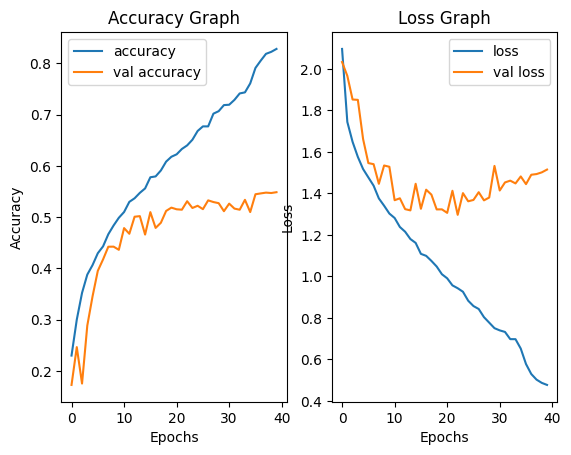

In [ ]:
# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Output: happy


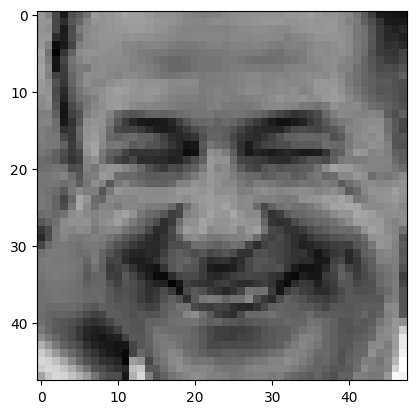

In [ ]:
# Test the model on a random image from the test set
image_index = random.randint(0, len(test))  # Pick image using random index number
print("Original Output:", test['label'][image_index]) # Display original label

# Predict the label using trained model
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1)) # Reshape to mathc model dimensions

# Decode predicted label back to original string with LabelEncoder
prediction_label = encode.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label) # Display predicted label

# Display test image in grayscale to see input
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');